# Credit Risk Ensemble Techniques

Following work book leverages the LendingClub data to build, evaluate and compare two ensemble algorithms to determine which algorithm results in the best performance between a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
%matplotlib inline

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [4]:
#Functions and Global variables

result_report = list()

def generate_report(title, ac, bac, report, bal_report):
    
    '''Returns the list contain classification report with Balance Accuracy Score.
        Appends to global list result_report with model scores.

        Parameters:
            title (str): Model title.
            ac (float): Accuracy Score
            bas (float): Balance Accuracy Score
            report (str): Classification Report
            bal_report (str): Imbalanced Classification Report
    '''
    
    result_report.append(title+"\n" 
                         + "Accuracy Score " + str(ac) + "\n"
                         + "Balanced Accuracy Score " + str(bac) + "\n"
                         + "Classification Report\n"
                         + report +"\n\n"
                         + "Imbalanced Classification Report\n"
                         + bal_report +"\n\n")
    
    

def generate_confusion_matrix(cm):
    '''Returns modified confusion matrix dataframe with titles.

       Parameters:
            cm (numpy.ndarray): Confusion Martix Object.
       
       Returns:
            cm_df: Confusion Matrix dataframe with labels. 

    '''
    
    cm_df = pd.DataFrame( cm, index=["Actual Low-Risk 0", "Actual High-Risk 1"],
            columns=["Predicted Low-Risk 0", "Predicted High-Risk 1"])

    return cm_df

# Read the CSV and Perform Basic Data Cleaning

In [5]:
# Load the data
file_path = Path('Resources/lending_data.csv')
df = pd.read_csv(file_path)

df.head()

,loan_size,interest_rate,homeowner,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,own,52800,0.431818,5,1,22800,low_risk
1,8400.0,6.692,own,43600,0.311927,3,0,13600,low_risk
2,9000.0,6.963,rent,46100,0.349241,3,0,16100,low_risk
3,10700.0,7.664,own,52700,0.430740,5,1,22700,low_risk
4,10800.0,7.698,mortgage,53000,0.433962,5,1,23000,low_risk


In [6]:
# Creating dummy colunms for the homeowner column
df = pd.get_dummies(df, columns=["homeowner"])
df.head()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status,homeowner_mortgage,homeowner_own,homeowner_rent
0,10700.0,7.672,52800,0.431818,5,1,22800,low_risk,0,1,0
1,8400.0,6.692,43600,0.311927,3,0,13600,low_risk,0,1,0
2,9000.0,6.963,46100,0.349241,3,0,16100,low_risk,0,0,1
3,10700.0,7.664,52700,0.430740,5,1,22700,low_risk,0,1,0
4,10800.0,7.698,53000,0.433962,5,1,23000,low_risk,1,0,0


# Split the Data into Training and Testing

In [7]:
df.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,homeowner_mortgage,homeowner_own,homeowner_rent
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.497472,0.398911,0.103616
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.499997,0.489678,0.304764
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000,0.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000,0.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,1.000000,1.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000,1.000000,1.000000


In [8]:
# Create our features
X = df.drop(columns="loan_status")

# Create our target
y = df["loan_status"]

In [9]:
X.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,homeowner_mortgage,homeowner_own,homeowner_rent
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.497472,0.398911,0.103616
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.499997,0.489678,0.304764
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000,0.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000,0.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,1.000000,1.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000,1.000000,1.000000


In [10]:
# Check the balance of our target values
y.value_counts()

low_risk     75036
high_risk     2500
Name: loan_status, dtype: int64

In [11]:
# Create X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

In [12]:
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [13]:
# Resample the training data with the BalancedRandomForestClassifier
brfc_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)


In [14]:
# Fitting the model
brfc_model = brfc_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = brfc_model.predict(X_test_scaled)

In [15]:
# Calculated the balanced accuracy score
bal_acc_score = balanced_accuracy_score(y_test, predictions)

In [16]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [17]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.81      1.00      0.99      0.89      0.99      0.99       625
   low_risk       1.00      0.99      1.00      1.00      0.99      0.99     18759

avg / total       0.99      0.99      1.00      0.99      0.99      0.99     19384



In [18]:
# Display the confusion matrix
print(generate_confusion_matrix(cm))

#Add classification reports to final analysis report list
generate_report("Analysis: Balanced Random Forest Classifier",
                acc_score, bal_acc_score, 
                classification_report(y_test, predictions),
               classification_report_imbalanced(y_test, predictions))

                    Predicted Low-Risk 0  Predicted High-Risk 1
Actual Low-Risk 0                    622                      3
Actual High-Risk 1                   147                  18612


In [19]:
# List the features sorted in descending order by feature importance
importances = brfc_model.feature_importances_
sorted(zip(brfc_model.feature_importances_, X.columns), reverse=True)

[(0.22759633831687995, 'borrower_income'),
 (0.1965574723230606, 'interest_rate'),
 (0.17417807060091195, 'debt_to_income'),
 (0.14944360428565667, 'total_debt'),
 (0.14229163194622926, 'loan_size'),
 (0.07859627283289125, 'num_of_accounts'),
 (0.02885770833789564, 'derogatory_marks'),
 (0.001219411955649641, 'homeowner_own'),
 (0.0008974701883394341, 'homeowner_mortgage'),
 (0.0003620192124855904, 'homeowner_rent')]

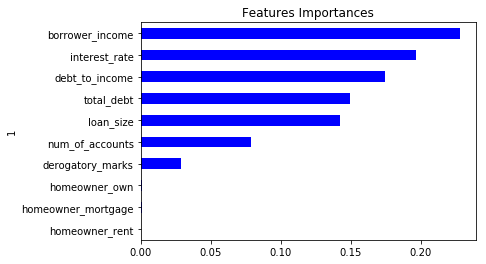

In [20]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(brfc_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='blue', title= 'Features Importances', legend=False)

### Easy Ensemble AdaBoost Classifier

In [21]:
# Create a Easy Ensemble AdaBoost classifier
abc_model = AdaBoostClassifier(n_estimators=100,
                         random_state=1)

In [71]:
# Fitting the model
abc_model = abc_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = abc_model.predict(X_test_scaled)

In [72]:
# Calculated the balanced accuracy score
bal_acc_score = balanced_accuracy_score(y_test, predictions)

In [73]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [74]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.86      1.00      0.99      0.92      0.99      0.99       625
   low_risk       1.00      0.99      1.00      1.00      0.99      0.99     18759

avg / total       1.00      0.99      1.00      0.99      0.99      0.99     19384



In [75]:
# Display the confusion matrix
print(generate_confusion_matrix(cm))


#Add classification report to final analysis report list
generate_report("Analysis: Easy Ensemble AdaBoost",
                acc_score, bal_acc_score, classification_report(y_test, predictions),
               classification_report_imbalanced(y_test, predictions))

                    Predicted Low-Risk 0  Predicted High-Risk 1
Actual Low-Risk 0                    622                      3
Actual High-Risk 1                   104                  18655


In [76]:
# List the features sorted in descending order by feature importance
importances = abc_model.feature_importances_
sorted(zip(abc_model.feature_importances_, X.columns), reverse=True)

[(0.98, 'interest_rate'),
 (0.01, 'total_debt'),
 (0.01, 'homeowner_mortgage'),
 (0.0, 'num_of_accounts'),
 (0.0, 'loan_size'),
 (0.0, 'homeowner_rent'),
 (0.0, 'homeowner_own'),
 (0.0, 'derogatory_marks'),
 (0.0, 'debt_to_income'),
 (0.0, 'borrower_income')]

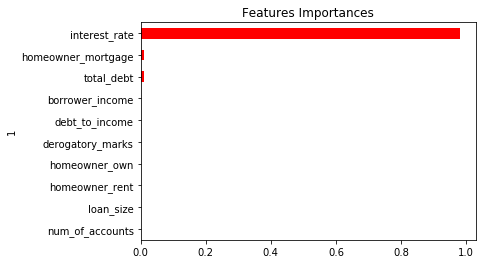

In [77]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(abc_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='red', title= 'Features Importances', legend=False)

# Analysis

In [78]:
#Display report results for all ensemble classifiers.
for i, val in enumerate(result_report): print(val)

Analysis: Balanced Random Forest Classifier
Accuracy Score 0.9922616591002889
Balanced Accuracy Score 0.9936818806972654
Classification Report
              precision    recall  f1-score   support

   high_risk       0.81      1.00      0.89       625
    low_risk       1.00      0.99      1.00     18759

    accuracy                           0.99     19384
   macro avg       0.90      0.99      0.94     19384
weighted avg       0.99      0.99      0.99     19384


Imbalanced Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.81      1.00      0.99      0.89      0.99      0.99       625
   low_risk       1.00      0.99      1.00      1.00      0.99      0.99     18759

avg / total       0.99      0.99      1.00      0.99      0.99      0.99     19384



Analysis: Easy Ensemble AdaBoost
Accuracy Score 0.9944799834915394
Balanced Accuracy Score 0.9948279972279972
Classification Report
              precision    

Similar to the results found in the resampling notebook, both classifiers did equally well with the AdaBoost scoring slightly better than the Random Forest in the Balanced Accuracy Score.  Out of the top three features, both classifiers picked the interest_rate, where AdaBoost ranked it as the most important at .98.  Random Forest ranked borrower_income at .23, interest_rate at .19 and debt_to_income at .17.  At a close inspection of the top three features, the selection does not make a lot of sense.  This might again allude to the imbalance mean distribution between each feature for high and low risk datasets.  

* Which model had the best balanced accuracy score?

| Classifier                        | Balanced Accuracy Score | 
|:----------------------------------|:------------------------|
| Balanced Random Forest Classifier | 0.9936818806972654      |
| Easy Ensemble AdaBoost            | 0.9948279972279972      |

* Which model had the best recall score?


| Classifier                        | Recall Score - high_risk | Recall Score - low_risk |
|:----------------------------------|:-------------------------|:-------------------------|
| Balanced Random Forest Classifier | 1.00       | 0.99|
| Easy Ensemble AdaBoost            | 1.00       | 0.99|


* Which model had the best geometric mean score?

| Classifier                        | Geometric Mean - high_risk | Geometric Mean - low_risk |
|:----------------------------------|:-------------------------|:-------------------------|
| Balanced Random Forest Classifier | 0.99       | 0.99|
| Easy Ensemble AdaBoost            | 0.99       | 0.99|


* What are the top three features?

| Classifier                        | Score | Feature |
|:----------------------------------|:------|:-------------------------|
| Balanced Random Forest Classifier | 0.22759  | borrower_income|
|                                   | 0.19655  | interest_rate|
|                                   | 0.17417  | debt_to_income|
| Easy Ensemble AdaBoost            | 0.98  | interest_rate|
|                                   | 0.01  | total_debt|
|                                   | 0.01  | homeowner_mortgage|
